## Capstone 3: Data Wrangling and EDA on X-Ray data set


## Install necassary libraries 

In [2]:
pip install opencv-python


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os

2025-01-25 18:29:27.786142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

## Data manipulation to perform EDA

Create a function that gets data from directory and lables it based on Normal or Pneumonia 

In [6]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)  # Numeric label for the category
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Skipping file {img} as it could not be read.")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize image
                data.append([resized_arr, class_num])  # Add image and label
            except Exception as e:
                print(f"Error processing file {img}: {e}")
    return np.array(data, dtype=object)  # Allow mixed data types (image, label)

In [7]:
print(os.getcwd())
#/Users/vcarrillo/Downloads/chest_xray/__MACOSX/chest_xray

/Users/vcarrillo/Downloads/chest_xray/__MACOSX/chest_xray


In [8]:
train = get_training_data('/Users/vcarrillo/Downloads/chest_xray/train')


In [9]:
print(len(train))

5216


In [10]:
test = get_training_data('/Users/vcarrillo/Downloads/chest_xray/test')

In [11]:
print(len(test))

624


In [12]:
val = get_training_data('/Users/vcarrillo/Downloads/chest_xray/val')

In [13]:
print(len(val))

16


/var/folders/yw/y4pg_jgd1337cpj1cjwrm82c0000gn/T/ipykernel_16706/1137843332.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_series, palette={"Pneumonia": "red", "Normal": "green"})


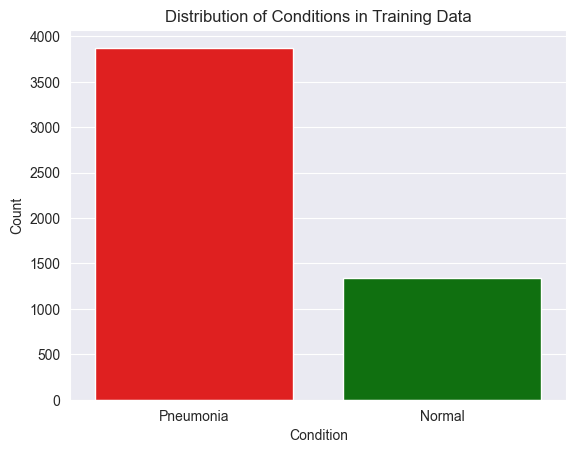

In [14]:
# Convert the list to a Pandas Series for Seaborn compatibility
list = []
for i in train:
    if i[1] == 0:
        list.append("Pneumonia")
    else:
        list.append("Normal")

# Convert to Pandas Series
label_series = pd.Series(list, name="Condition")

# Plot with Seaborn
sns.set_style('darkgrid')
sns.countplot(x=label_series, palette={"Pneumonia": "red", "Normal": "green"})

# Add titles and labels
plt.title("Distribution of Conditions in Training Data")
plt.xlabel("Condition")
plt.ylabel("Count")
plt.show()

/var/folders/yw/y4pg_jgd1337cpj1cjwrm82c0000gn/T/ipykernel_16706/597521069.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_series, palette={"Pneumonia": "red", "Normal": "green"})


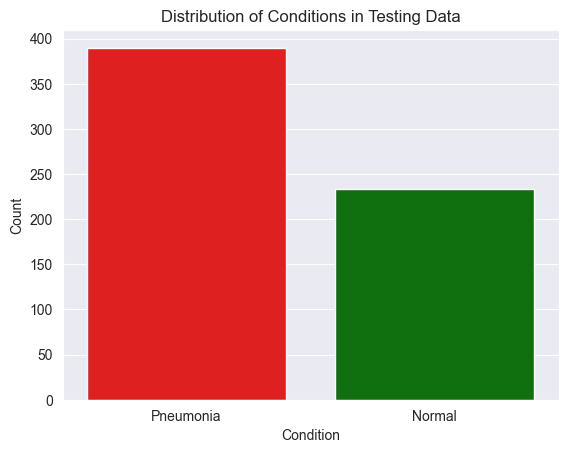

In [15]:
# Convert the list to a Pandas Series for Seaborn compatibility
list2 = []
for i in test:
    if i[1] == 0:
        list2.append("Pneumonia")
    else:
        list2.append("Normal")

# Convert to Pandas Series
label_series = pd.Series(list2, name="Condition")

# Plot with Seaborn
sns.set_style('darkgrid')
sns.countplot(x=label_series, palette={"Pneumonia": "red", "Normal": "green"})

# Add titles and labels
plt.title("Distribution of Conditions in Testing Data")
plt.xlabel("Condition")
plt.ylabel("Count")
plt.show()

In [16]:
#Count number of conditions 
label_series.value_counts()

Condition
Pneumonia    390
Normal       234
Name: count, dtype: int64

In [17]:
#Total number of images in training set 
label_series.value_counts().sum()

624

## Observation: Dataset is imbalanced, this might affect results. 

## Possible Soluntions: Oversampling, undersampling, or data augmentation. 

In [18]:
label_series.describe()

count           624
unique            2
top       Pneumonia
freq            390
Name: Condition, dtype: object

In [19]:
print(f"Training set size: {len(train)}")
print(f"Validation set size: {len(val)}")
print(f"Test set size: {len(test)}")


Training set size: 5216
Validation set size: 16
Test set size: 624


## Visualizing differences in pixel intensity between Normal and Pneumonia 

In [20]:
print(type(train))

<class 'numpy.ndarray'>


### 0 is Normal and 1 is Pneumonia 

In [21]:
# Separate images by condition normal and pneumonia 
normal_images = train[train[:, 1] == 0][:, 0]  # Images with 0 are Normal
pneumonia_images = train[train[:, 1] == 1][:, 0]  # Images with label 1 are Pneumonia



In [22]:
# Flatten pixel values for each class
def flatten_pixel_intensities(images):
    intensities = []
    for img in images:
        intensities.extend(img.ravel())  # Flatten and collect pixel values
    return np.array(intensities)

# Calculate pixel intensities
normal_intensities = flatten_pixel_intensities(normal_images)
pneumonia_intensities = flatten_pixel_intensities(pneumonia_images)


In [23]:
#Mean for normal intensities 
normal_intensities.mean()

123.0886053046595

In [24]:
#Median of normal images intensity 
np.median(normal_intensities)

134.0

In [25]:
#Mean for Pneumonia intensities 
pneumonia_intensities.mean()

122.27166668323805

In [26]:
#Median of pneumonia images intensity 
np.median(pneumonia_intensities)

132.0

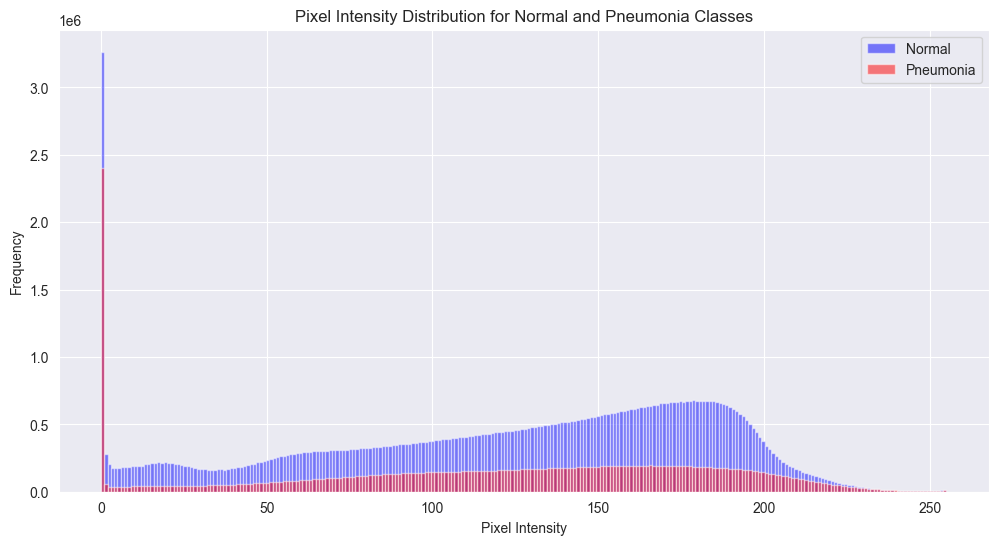

In [27]:
#Visualize the difference in intensity between both conditions.

#Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(normal_intensities, bins=256, alpha=0.5, label='Normal', color='blue', range=(0, 255))
plt.hist(pneumonia_intensities, bins=256, alpha=0.5, label='Pneumonia', color='red', range=(0, 255))
plt.title('Pixel Intensity Distribution for Normal and Pneumonia Classes')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()



## Observation: Pixel intensity seems to be an important feature in seperating X-Ray images with and without Pneumonia. 

## Visualizing some of the training data images

Text(0.5, 1.0, 'NORMAL')

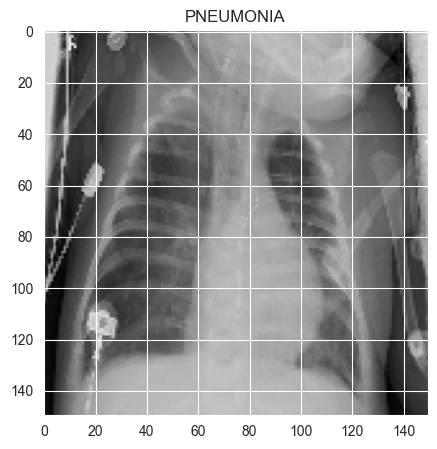

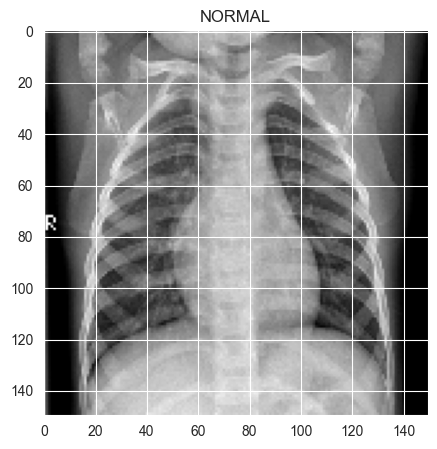

In [28]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

### Preprocessing and Training Data Development, Modeling, and Documentation.

The following steps should be completed in a Jupyter Notebook, python scripts, or in
Paperspace. 

Preprocessing and Training Data Development
Goal: Create a cleaned development dataset you can use to complete the
modeling step of your project.
Steps: 
● Create dummy or indicator features for categorical variables
● Standardize the magnitude of numeric features using a scaler
● Split into testing and training datasets 

Review the following questions and apply them to your dataset:
● Does my data set have any categorical data, such as Gender or day of the week?
● Do my features have data values that range from 0 - 100 or 0-1 or both and more? 

# Preprocessing 

### Data Augmentation with Keras ImageDataGenerator


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. rescale=1/255.
- This is a preprocessing step that normalizes pixel values.
- Converts pixel values from original 0-255 range to 0-1 range.
- This helps the neuarl network process the data more effectively by scaling down the input values.
- Important for consitent and faster model training. 


# 2. rotating_range=0.2:
- Randomly rotates images during training by up to 20 degrees.
- This increases the robustness of the model by adding variations in image orientation. 
- This will help since not all X-ray images might have same orientation.


# 3. width_shift_range=0.2:
- Permits horizontal shifting of up to 20% of the image width.
- Helps increase robustness of model since it has to learn to recognize features regardless of their orientation.
- Helps model to generalize. 

# 4. height_shift_range=0.2:
- Just like width shift but vertically.
- Allows vertical shift of images up to 20%. 
- Helps model to generalize better.

# 5. zoom_range=0.2:
- Randomly zooms in or out of images by up to 20%.
- Helps model to recognize features at different scales.
- Helps model generalize with medical images since scale may vary. 

# 6. horizontal_flip=True:
- Randomly flips images horizontally.
- Can be useful for some datasets but it should be used with caution. 
- Note: For medical images anatomical symmetry matters so it this might not be helpful!

In [30]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                   )
test_datagen = ImageDataGenerator(rescale=1/255.)

In [31]:
train_dir = '/Users/vcarrillo/Downloads/chest_xray/train'

In [32]:
test_dir = '/Users/vcarrillo/Downloads/chest_xray/test'

In [33]:
train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              color_mode='grayscale',
                                              class_mode='binary')
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            color_mode='grayscale',
                                            class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Modeling

### Build CNN model and complie.

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 1)),#16 filters, 3x3 kernel, ReLU activation, input shape 244x244x1
    tf.keras.layers.MaxPooling2D(2, 2),#MaxPooling layers after each convolution to reduce spatial dimensions
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),#progressivley increasing filter count from 16 to 32 to 64
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 1)),#Each conv layer reduces image size while extracting more complex features
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),#converts 2D feature mapes to 1D vector
    tf.keras.layers.Dense(100, activation='relu'),#100 neurons, ReLU activation
    tf.keras.layers.Dense(1, activation='sigmoid')#1 neuron with sigmoid activation for binary classification.
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
#Complie model 
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [36]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,326,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,349,897 (16.59 MB)

 Trainable params: 4,349,897 (16.59 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
#Training model with specific training parameters:

history = model.fit(train_data,
                   epochs=20,#model trains for 10 complete epochs
                   steps_per_epoch=len(train_data),#uses all training batches for validation
                   validation_data=test_data,#Uses test data for validation
                   validation_steps=len(test_data))#Uses all test batches for validation 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 792ms/step - accuracy: 0.7682 - loss: 0.5109 - val_accuracy: 0.8013 - val_loss: 0.4610
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 779ms/step - accuracy: 0.8584 - loss: 0.3067 - val_accuracy: 0.7115 - val_loss: 0.7918
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 784ms/step - accuracy: 0.8588 - loss: 0.3070 - val_accuracy: 0.8381 - val_loss: 0.3705
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 776ms/step - accuracy: 0.8953 - loss: 0.2360 - val_accuracy: 0.8413 - val_loss: 0.3541
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 778ms/step - accuracy: 0.8945 - loss: 0.2363 - val_accuracy: 0.8413 - val_loss: 0.3659
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 810ms/step - accuracy: 0.8981 - loss: 0.2310 - val_accuracy: 0.8333 - val_loss: 0.3939
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 817ms/step - accuracy: 0.9061 - loss: 0.2184 - val_accuracy: 0.8814 - val_loss: 0.3115
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 785ms/step - accuracy: 0.9177 -

# Potential Improvements:

- Adding Dropout layers
- Experiment with batch normalization
- Regularization techniques

In [38]:
#Visualize accuracy and loss curve
def plot_accuracy_curve(history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['accuracy']))

  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

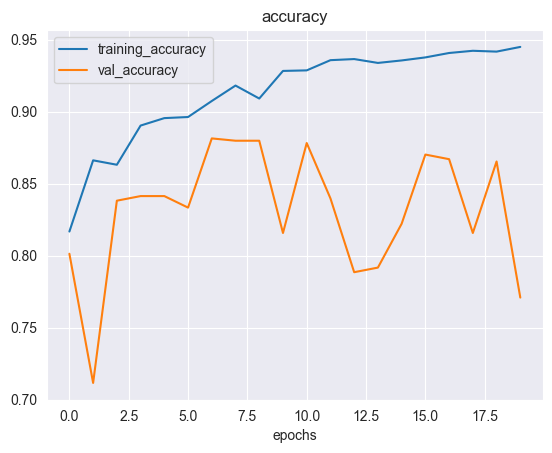

In [39]:
plot_accuracy_curve(history)

In [40]:
#Loss curve:
def plot_loss_curve(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

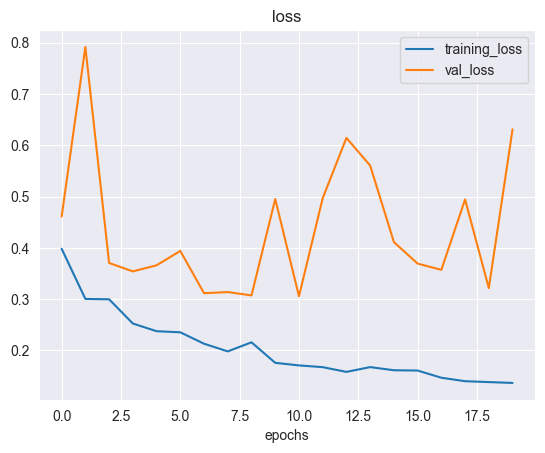

In [41]:
plot_loss_curve(history)

# Evaluation of model

In [42]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.7611 - loss: 0.6471
Test Accuracy: 77.08%


In [43]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict test data
y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_data.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step
Confusion Matrix:
[[ 49 185]
 [ 52 338]]


In [44]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.49      0.21      0.29       234
           1       0.65      0.87      0.74       390

    accuracy                           0.62       624
   macro avg       0.57      0.54      0.52       624
weighted avg       0.59      0.62      0.57       624



# Observations:

## 0 = Normal 

### Precision score of 49% for Normal
### Recall score: 21% for Normal 

## 1 = Pneumonia

### Precision Score: 65% for Pneumonia 
### Recall Score: 87% for Pneumonia


Notes: Model does great when identifying X-ray images of Pneumonia patients. I suspect that overfitting might be a factor.

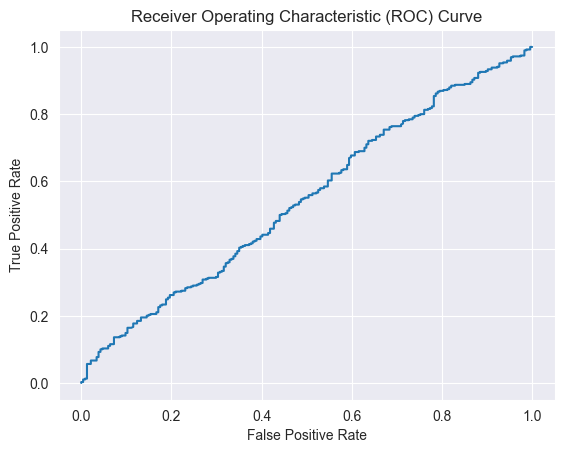

In [45]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

# Potential Improvements to the model 
- 1. BatchNormalization
- 2. Dropout: To prevent overfitting
- 3. L2 Regularization: Reduces model complexity.

In [47]:
from tensorflow.keras.regularizers import l2

In [48]:

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), 
                           activation='relu', 
                           input_shape=(224, 224, 1),
                           kernel_regularizer=l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(32, (3, 3), 
                           activation='relu',
                           kernel_regularizer=l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), 
                           activation='relu',
                           kernel_regularizer=l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(100, 
                          activation='relu', 
                          kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
# Compile the model
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:

history2 = model_2.fit(train_data,
                   epochs=20,
                   steps_per_epoch=len(train_data),
                   validation_data=test_data,
                   validation_steps=len(test_data))

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.7303 - loss: 2.3436 - val_accuracy: 0.6250 - val_loss: 46.9513
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.8495 - loss: 0.6276 - val_accuracy: 0.6250 - val_loss: 56.5457
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.8551 - loss: 0.5702 - val_accuracy: 0.6250 - val_loss: 23.7610
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.8706 - loss: 0.5384 - val_accuracy: 0.6250 - val_loss: 12.4310
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.8814 - loss: 0.6660 - val_accuracy: 0.7821 - val_loss: 0.9349
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.8902 - loss: 0.5896 - val_accuracy: 0.6667 - val_loss: 3.4201
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.8960 - loss: 0.4976 - val_accuracy: 0.5240 - val_loss: 1.1928
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.8893 - loss: 0.4846 - val_

In [51]:
# Predict test data
y_pred = model_2.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_data.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 400ms/step
Confusion Matrix:
[[ 37 197]
 [ 66 324]]


In [52]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.36      0.16      0.22       234
           1       0.62      0.83      0.71       390

    accuracy                           0.58       624
   macro avg       0.49      0.49      0.47       624
weighted avg       0.52      0.58      0.53       624



# Observations:

## 0 = Normal 

Precision score:  36% for Normal
Recall score: 16% for Normal 

## 1 = Pneumonia
Precision Score: 62% for Pneumonia 
Recall Score: 83% for Pneumonia

Notes: A recall score of 46% for Pneumonia is terrible as the cost of misidentifying a patient with pneumonia could be fatal!

In [56]:
# Evaluate on test data
test_loss, test_accuracy = model_2.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.7572 - loss: 2.5970
Test Accuracy: 72.92%


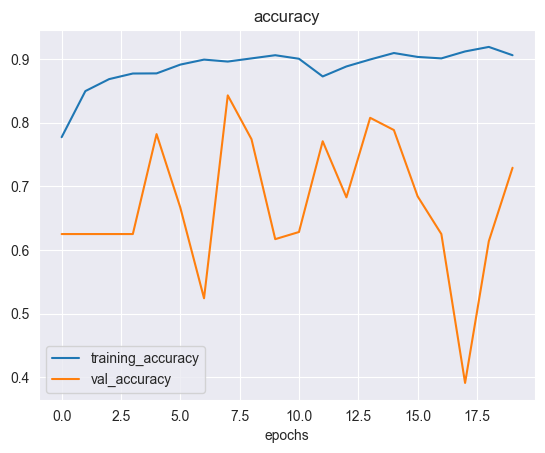

In [57]:
plot_accuracy_curve(history2)

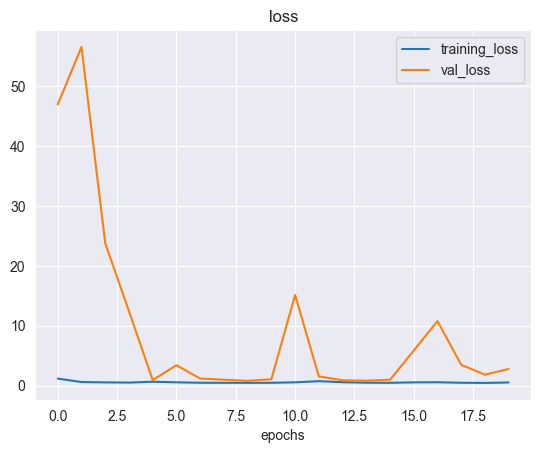

In [58]:
plot_loss_curve(history2)

### Final Thoughts:

Both models performances should improve with increased number of training epochs. The ideal number of epochs for medical images is 50. 

- Given resource restrictions on my laptop I only trained my first model on 10 epochs. Its recall score for Pneumonia detection was 88%.
- My second model performed worse at identifying patients with Pneumonia but it was an improvement from the first in identifyiing patients with out Pneumonia. 


# Conclusion: Given that my stated goal was to develop a model that was effective at identifying X-ray images of patients with Pneumonia my first model achieved a Rella socre of 88%. While this leaves room for improvement considering that not identifying a patient with Pneumonia can have catostrophic consequences, this is a great first step. 

# Future steps: 

1. Retrain model on at least 50 epochs as this is the suggested number for medical imaging.

2. Use oversampling techniques on Pneumonia images to increase recall score of this class. 

3. Add additional convolutional layers to increase complexity.

4. Use transfer learning with pre-trained models.

5. Adjust Thresholds. 